In [106]:
import os
import time
from tempfile import TemporaryDirectory
from PIL import Image

import numpy as np
import math
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import datasets, transforms
import torchvision.models as models
import torchvision.transforms.v2 as v2   

cudnn.benchmark = True
plt.ion()   # interactive mode

In [107]:
# Model you would like to use
model = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)

In [108]:
# Data loading code
height=224
width=224
batch_size = 32

transform = transforms.Compose([
    transforms.Resize((height, width)),
    transforms.ToTensor(), # Converts regular images into tensors from 0-255 to 0.0-1.0.
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]) 
    ]) 

## Data augmentation
# Random Perspective
transform_rp = transforms.Compose([
    transforms.Resize((height, width)),
    transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]) 
])

# Random Rotation
transform_rr = transforms.Compose([
    transforms.Resize((height, width)),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]) 
])

# Dataset
train_root = r'INSERT PATH HERE' # Path to training dataset
val_root = r'INSERT PATH HERE' # Path to validation dataset
test_root = r'INSERT PATH HERE' # Path to the testing dataset

# Train dataset concatenation
train_ds1 = torchvision.datasets.ImageFolder(root=train_root, transform=transform)
train_ds2 = torchvision.datasets.ImageFolder(root=train_root, transform=transform_rp)
train_ds3 = torchvision.datasets.ImageFolder(root=train_root, transform=transform_rr)
train_dataset = torch.utils.data.ConcatDataset([train_ds1, train_ds2, train_ds3])

val_dataset = torchvision.datasets.ImageFolder(root=val_root, transform=transform)

# Dataloader
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

dataloaders = {'train': trainloader, 'val': valloader}

train_size = len(train_dataset)
val_size = len(val_dataset)
dataset_sizes = {'train': train_size, 'val': val_size}
print(f'train dataset size: {train_size}, val dataset size: {val_size}')

train_root_dataset = torchvision.datasets.ImageFolder(root=train_root)
class_names = train_root_dataset.classes
print(class_names)

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print (f"Using {device} device")

train dataset size: 15648, val dataset size: 624
['NORMAL', 'PNEUMONIA']
Using cuda device


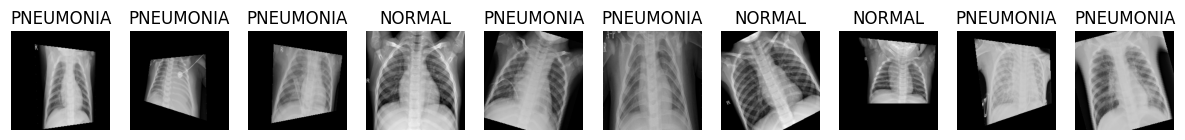

In [109]:
# Visualisation of a few images

import matplotlib.pyplot as plt
import numpy as np
import random

def imgprev(dataset, class_names, num_images=5):
    # Random indices
    randind = random.sample(range(len(dataset)), num_images)
    
    plt.figure(figsize=(15, 5))
    
    for idx, i in enumerate(randind):
        img, label = dataset[i]  # unpack image and label
        
        # Unnormalise the images
        img = img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
        npimg = img.numpy()
        
        # Plot each image in a subplot
        ax = plt.subplot(1, num_images, idx + 1)
        ax.imshow(np.transpose(npimg, (1, 2, 0)))  # Convert CHW -> HWC
        ax.axis('off')
        ax.set_title(class_names[label])
    
    plt.show()

# Display the images
imgprev(train_dataset, class_names, num_images=10)

In [110]:
# Visualisation function

def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [111]:
# Visualising the model predictions
def visualise_model(model, num_images=6):
    was_training = model.training
    model.eval()
    
    fig, axes = plt.subplots(1, num_images, figsize=(num_images*3, 3))  # 1 row, num_images columns
    if num_images == 1:
        axes = [axes]  # ensure axes is always iterable

    images_so_far = 0

    with torch.no_grad():  # No need to track gradients
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # output -> (max value, index)

            for j in range(inputs.size()[0]):
                ax = axes[images_so_far]
                ax.axis('off')

                # Show predicted and true labels in the title
                ax.set_title(f'predicted: {class_names[preds[j]]}\ntrue: {class_names[labels[j]]}')

                # Convert tensor to numpy for plotting
                img = inputs.cpu().data[j]
                img = img.numpy().transpose((1, 2, 0))
                # Unnormalize
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img = std * img + mean
                img = np.clip(img, 0, 1)
                
                ax.imshow(img)

                images_so_far += 1
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    plt.tight_layout()
                    return

    model.train(mode=was_training)
    plt.tight_layout()

In [8]:
# Training the model
# Continuation of the transfer learning code:
# https://docs.pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
def train_model(model, criterion, optimiser, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10) # prints 10 dashes 

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train() # Set model to training mode
                else:
                    model.eval() # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimiser.zero_grad() # zeros out the gradient else the gradient will accumulate by default.

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'): # turns on gradient tracking for training
                        outputs = model(inputs) # input [batch_size, R, G, B] -> output [batch_size, num_classes]
                        _, preds = torch.max(outputs, 1) # output -> (max value, index)
                        # Finds the maximum value across dim 1 (rows) and _ ignores the value of max.
                        # _ is the value, preds is the index position. Index position represents the predicted label.
                        loss = criterion(outputs, labels)

                    # backward + optimise only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimiser.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0) # loss.item() is average loss for the batch. input.size(0) is batch size.
                    # running_loss is the total accumulated loss from all images processed so far.
                    running_corrects += torch.sum(preds == labels.data) # count howm any predictions match the true labels
                if phase == 'train':
                    scheduler.step() # Adjust learning rate after each training epoch. 
                    # Scheduler decays the learning rate.

                epoch_loss = running_loss / dataset_sizes[phase] # average loss per image = total loss / total images 
                epoch_acc = running_corrects.double() / dataset_sizes[phase] # accuracy = total correct images / total images

                print(f'{phase} Loss: {epoch_loss: .4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc: # epoch accuracy has to be better than best_acc to save best model.
                    best_acc = epoch_acc 
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60: .0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [9]:
# Finetuning the ResNet (across all layers)
if False: # This is to stop the block from running.
    model_ft = model # Load the model
    num_ftrs = model_ft.fc.in_features # num of input features to the final layer
    model_ft.fc = nn.Linear(num_ftrs, len(class_names)) # num of input features, num of output features
    
    model_ft = model_ft.to(device) # Sends model to device
    criterion = nn.CrossEntropyLoss() # Loss function -> categorical cross-entropy
    
    # Observe that all parameters are being optimised
    optimiser_ft = optim.SGD(model_ft.parameters(), lr=1e-4, momentum=0.9) # Stochastic Gradient Descent optimiser
    
    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimiser_ft, step_size=7, gamma=0.1)

In [10]:
## Train and evaluate
#model_ft = train_model(model_ft, criterion, optimiser_ft, exp_lr_scheduler, num_epochs=25)

In [11]:
#visualise_model(model_ft)

In [116]:
# ResNet as fixed feature extractor
model_conv = model
for param in model_conv.parameters():
# iterates over all the parameters in ResNet model
    param.requires_grad = False # freeze the pretrained layers 

# Unfreezes layer 4 
for param in model_conv.layer4.parameters():
    param.requires_grad = True

num_ftrs = model_conv.fc.in_features # num of input features to the final layer
model_conv.fc = nn.Linear(num_ftrs, len(class_names)) # num of input features, num of output features
# replaces fc with a new layer. Parameters of newly constructed modules have requires_grad=True by default.

model_conv = model_conv.to(device) # Sends model to device
criterion = nn.CrossEntropyLoss() # loss function -> categorical cross-entropy

# Optimiser
optimiser_params = [
    {'params': model_conv.layer4.parameters(), 'lr': 1e-4},
    {'params': model_conv.fc.parameters(), 'lr': 1e-3}
]
optimiser_conv = optim.SGD(optimiser_params, momentum=0.9, weight_decay=1e-4) 
# optimiser_conv = optim.AdamW(optimiser_params, lr=1e-4) 
# Could manipulate the code above to allow for more refined control of the individual layers in terms of it's hyperparameters?

# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimiser_conv, step_size=7, gamma=0.1)
exp_lr_scheduler = lr_scheduler.CosineAnnealingLR(optimiser_conv, T_max=10)

In [117]:
# Train and evaluate
model_conv = train_model(model_conv, criterion, optimiser_conv, exp_lr_scheduler, num_epochs=15)

Epoch 0/14
----------
train Loss:  0.2853 Acc: 0.8852
val Loss:  0.4001 Acc: 0.8141

Epoch 1/14
----------
train Loss:  0.1940 Acc: 0.9248
val Loss:  0.3796 Acc: 0.8317

Epoch 2/14
----------
train Loss:  0.1706 Acc: 0.9365
val Loss:  0.4106 Acc: 0.8285

Epoch 3/14
----------
train Loss:  0.1582 Acc: 0.9413
val Loss:  0.4393 Acc: 0.8205

Epoch 4/14
----------
train Loss:  0.1526 Acc: 0.9423
val Loss:  0.4814 Acc: 0.8109

Epoch 5/14
----------
train Loss:  0.1492 Acc: 0.9422
val Loss:  0.4304 Acc: 0.8333

Epoch 6/14
----------
train Loss:  0.1436 Acc: 0.9454
val Loss:  0.4381 Acc: 0.8285

Epoch 7/14
----------
train Loss:  0.1432 Acc: 0.9464
val Loss:  0.3957 Acc: 0.8510

Epoch 8/14
----------
train Loss:  0.1393 Acc: 0.9479
val Loss:  0.4184 Acc: 0.8413

Epoch 9/14
----------
train Loss:  0.1410 Acc: 0.9473
val Loss:  0.4237 Acc: 0.8365

Epoch 10/14
----------
train Loss:  0.1400 Acc: 0.9482
val Loss:  0.4165 Acc: 0.8397

Epoch 11/14
----------
train Loss:  0.1381 Acc: 0.9480
val Loss:

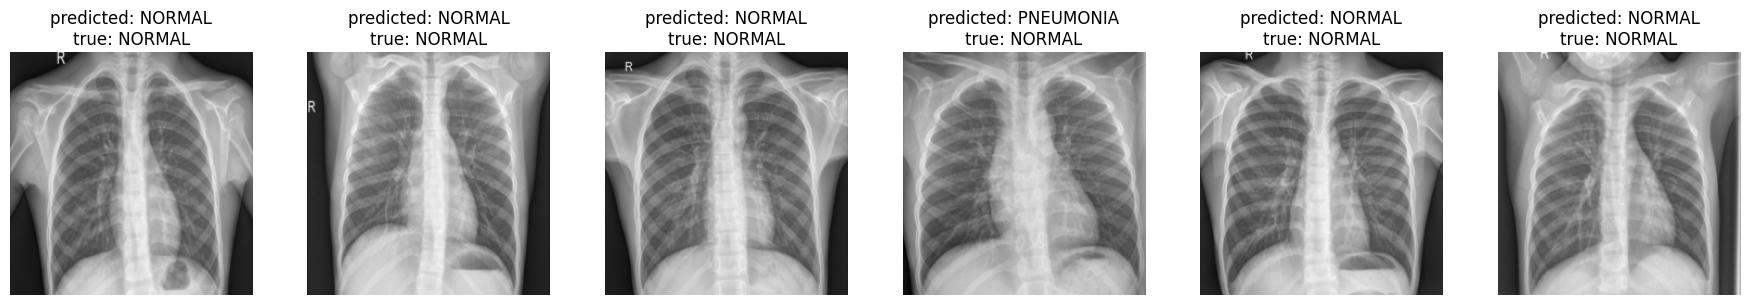

In [118]:
visualise_model(model_conv)

plt.ioff()
plt.show()

In [119]:
# Inference on a singular custom images
# Inference - makes prediction with fixed weights, no learning happens.
#if False: # This is to stop the block from running.
if False:
    def visualise_model_predictions(model,img_path):
        was_training = model.training
        model.eval()
    
        img = Image.open(img_path)
        img = transform(img)
        img = img.unsqueeze(0) # adds batch dimension, PyTorch expects shape [batch_shape, channels, height, width]
        img = img.to(device)
    
        with torch.no_grad():
            outputs = model(img)
            _, preds = torch.max(outputs, 1)
    
            ax = plt.subplot(2,2,1)
            ax.axis('off')
            ax.set_title(f'Predicted: {class_names[preds[0]]}')
            imshow(img.cpu().data[0])
    
            model.train(mode=was_training)

In [120]:
# Inference on the respective custom image
#if False: # This is to stop the block from running.
if False:
    visualise_model_predictions(
            model_conv,
            img_path=r'C:\Users\Work\Documents\GitHub\Crane\test.jpg'
        )
        
    plt.ioff()
    plt.show()

In [121]:
# Inference and visualisation on a testing dataset
def inf_vis_test(model, test_dataset_path):
    # Inference loop
    was_training = model.training
    model.eval()

    all_labels = []
    all_preds = []
    # Loading in the test dataset
    test_dataset = torchvision.datasets.ImageFolder(root=test_dataset_path, transform=transform)
    testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

    for batch_index, (inputs, labels) in enumerate(testloader):
        print(f"Processing batch {batch_index + 1} / {len(testloader)}")
        
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Appending all the labels into one list.
        all_labels.append(labels.cpu().numpy()) # NumPy can only handle CPU tensors, not GPU tensors.
        
        with torch.no_grad():
            outputs = model(inputs)
            _, y_pred = torch.max(outputs, 1)
            all_preds.append(y_pred.cpu().numpy()) 

    y_true = np.concatenate(all_labels)
    y_pred = np.concatenate(all_preds)
    
    # Visualisation
    num_images = 10  # Number of images to show
    cols = 5
    rows = (num_images + cols - 1) // cols  # Ceiling division to get enough rows
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    axes = axes.flatten()
    images_so_far = 0
    
    for i in range(inputs.size(0)):
        if images_so_far == num_images:
            break  # Stop once we have displayed the desired number of images
    
        ax = axes[images_so_far]
        ax.axis('off')
    
        # Show predicted and true labels in the title
        ax.set_title(f'Predicted: {class_names[y_pred[i]]}\nTrue: {class_names[labels[i]]}')
    
        # Convert tensor to numpy for plotting
        img = inputs.cpu().data[i].numpy().transpose((1, 2, 0))
        # Unnormalize
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
    
        ax.imshow(img)
        images_so_far += 1
    
    # Turn off any remaining empty axes
    for j in range(images_so_far, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    model.train(mode=was_training)

    return y_true, y_pred

Processing batch 1 / 20
Processing batch 2 / 20
Processing batch 3 / 20
Processing batch 4 / 20
Processing batch 5 / 20
Processing batch 6 / 20
Processing batch 7 / 20
Processing batch 8 / 20
Processing batch 9 / 20
Processing batch 10 / 20
Processing batch 11 / 20
Processing batch 12 / 20
Processing batch 13 / 20
Processing batch 14 / 20
Processing batch 15 / 20
Processing batch 16 / 20
Processing batch 17 / 20
Processing batch 18 / 20
Processing batch 19 / 20
Processing batch 20 / 20


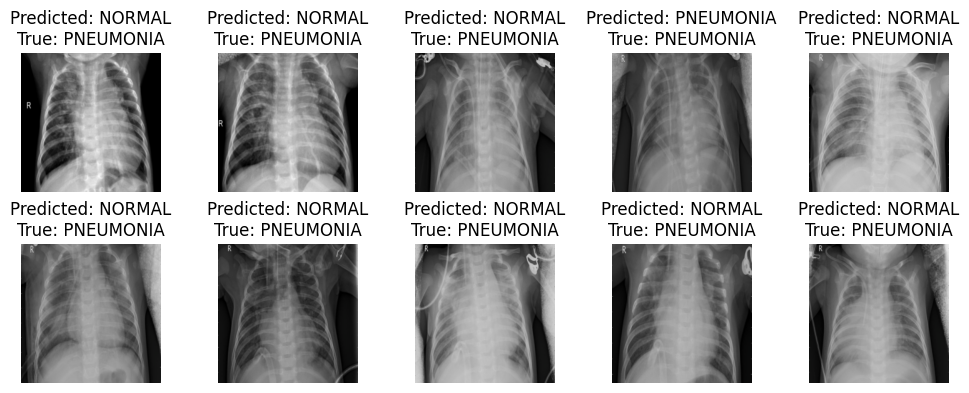

In [122]:
y_true, y_pred = inf_vis_test(
        model_conv,
        test_dataset_path=test_root
    )
    
plt.ioff()
plt.show()

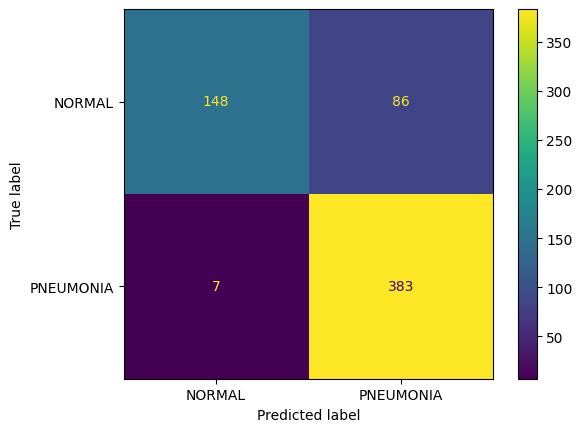

Accuracy:  0.8510
Precision: 0.8685
Recall:    0.8510
F1 Score:  0.8427


In [124]:
# Measuring metrics
from sklearn import metrics

# Confusion matrix
cm = metrics.confusion_matrix(y_true, y_pred)
cmd = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
cmd.plot()
plt.show()

# Metrics 
accuracy = metrics.accuracy_score(y_true, y_pred) 
precision = metrics.precision_score(y_true, y_pred, average='weighted')
recall = metrics.recall_score(y_true, y_pred, average='weighted')
f1 = metrics.f1_score(y_true, y_pred, average='weighted')

# Print results
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")